# Objective - 
### To build a logistic regression model before and after handling an imbalanced dataset.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from imblearn.over_sampling import RandomOverSampler

D:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Pre-processing

In [61]:
df = pd.read_csv('../datasets/adult.csv', sep=',', header=None)
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 
              'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

In [62]:
# Selecting only categorical variables
col_names = df.columns[df.dtypes == 'object']
col_names = col_names[:len(col_names)-1] # removing target variable
col_names

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

In [63]:
# Replacing missing values (?) with NaN
df.replace(" ?", np.nan, inplace=True)

In [64]:
# Replacing NaN with the mode of the categorical data
for i in range(len(col_names)):
    df.loc[:,col_names[i]] = df.loc[:,col_names[i]].fillna(df.loc[:,col_names[i]].mode()[0])

In [74]:
# One hot encoding
ndf = pd.DataFrame()
for i in range(len(col_names)):
    ndf = pd.concat([ndf, pd.get_dummies(df.loc[:,col_names[i]], prefix=col_names[i][0:4])], axis=1)

In [75]:
# Making a final dataframe
df = pd.concat([ndf, df.loc[:,['age', 'fnlwgt', 'education-num', 'capital-gain', 
                               'capital-loss', 'hours-per-week', 'income']]], axis=1)

In [105]:
# Mapping binary classes to 0 and 1
df['income'] = df['income'].apply(lambda x: 1 if x == " >50K" else 0)

In [106]:
# Creating a copy (to be used later)
df_temp = df.copy()

### Doing Random Over Sampling

In [107]:
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_sample(df.iloc[:,:105], df.iloc[:,105])

### Building model on balanced data

In [108]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.30, random_state = 42)

In [109]:
from  sklearn.linear_model  import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [110]:
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

In [111]:
from sklearn.metrics import classification_report
train_rep = classification_report(y_train, model.predict(X_train)).split("\n")[5].split("     ")[1:]
test_rep = classification_report(y_test, model.predict(X_test)).split("\n")[5].split("     ")[1:]

In [113]:
from sklearn.metrics import roc_auc_score
train_auc = roc_auc_score(y_train, model.predict(X_train))
test_auc = roc_auc_score(y_test, model.predict(X_test))

### Building model on non-sampled data

In [114]:
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(df_temp.iloc[:,:105], 
                                                                df_temp.iloc[:,105], test_size = 0.30, random_state = 42)
model_ns = LogisticRegression()
model_ns.fit(X_train_ns, y_train_ns)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [132]:
train_acc_ns = model_ns.score(X_train_ns, y_train_ns)
test_acc_ns = model_ns.score(X_test_ns, y_test_ns)

In [133]:
train_rep_ns = classification_report(y_train_ns, model_ns.predict(X_train_ns)).split("\n")[5].split("     ")[1:]
test_rep_ns = classification_report(y_test_ns, model_ns.predict(X_test_ns)).split("\n")[5].split("     ")[1:]

In [134]:
train_auc_ns = roc_auc_score(y_train_ns, model_ns.predict(X_train_ns))
test_auc_ns = roc_auc_score(y_test_ns, model_ns.predict(X_test_ns))

In [135]:
# Creating a dataframe to store all metrics
res = pd.DataFrame(0, index=['accuracy', 'precision', 'recall', 'f1-score', 'support', 'AUC'], 
                 columns=['Sampled_Train', 'Sampled_Test', 'Non_Sampled_Train', 'Non_Sampled_Test'])

In [137]:
res.Sampled_Train[0] = train_acc
res.Sampled_Train[1:5] = train_rep
res.Sampled_Train[5] = train_auc
res.Sampled_Test[0] = test_acc
res.Sampled_Test[1:5] = test_rep
res.Sampled_Test[5] = test_auc

res.Non_Sampled_Train[0] = train_acc_ns
res.Non_Sampled_Train[1:5] = train_rep_ns
res.Non_Sampled_Train[5] = train_auc_ns
res.Non_Sampled_Test[0] = test_acc_ns
res.Non_Sampled_Test[1:5] = test_rep_ns
res.Non_Sampled_Test[5] = test_auc_ns

res

,Sampled_Train,Sampled_Test,Non_Sampled_Train,Non_Sampled_Test
accuracy,0.821775,0.818972,0.795674,0.802129
precision,0.82,0.82,0.78,0.79
recall,0.82,0.82,0.80,0.80
f1-score,0.82,0.82,0.76,0.76
support,34608,14832,22792,9769
AUC,0.821816,0.818857,0.613639,0.616448


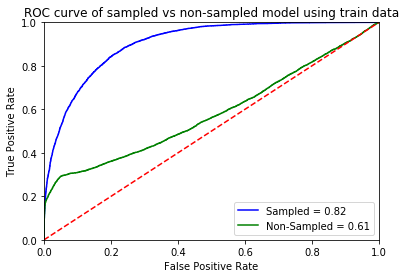

In [146]:
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_train, model.predict_proba(X_train)[:,1])
fpr_ns, tpr_ns, thres_ns = roc_curve(y_train_ns, model_ns.predict_proba(X_train_ns)[:,1])
plt.plot(fpr, tpr, 'b', label = 'Sampled = %0.2f' % train_auc)
plt.plot(fpr_ns, tpr_ns, 'g', label = 'Non-Sampled = %0.2f' % train_auc_ns)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve of sampled vs non-sampled model using train data')
plt.show()